In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

In [3]:
class DifferentialEquationSolution:
    def __init__(self, equation, solving_function, h = 0.01, title = "Untitled solution", exact = False):
        self.equation = equation
        self.solving_function = solving_function
        self.title = title
        self.exact = exact
        
        self.update(h)
  
    def __repr__(self):
        return f"<{self.title} of {self.equation}>"
    
    def __str__(self):
        return self.title + "\nt: " + str(self.t_list) + "\nx: " + str(self.x_list)
    
    def update(self, h):
        self.h = h
        self.t_list = np.arange(self.equation.t0, self.equation.t_max + h, h)
        self.x_list = self.solving_function(self.t_list, self.equation.f, self.equation.x0)
        
    def update_plot(self):
        self.plot_line.set_data(self.t_list, self.x_list)

In [26]:
class DifferentialEquation:
    def __init__(self, f, x0, t0 = 0, t_max = 1):
        self.f = f
        self.x0 = x0
        self.t0 = t0
        self.t_max = t_max
        self.solutions = []
        
    def add_solution(self, solving_function, h = 0.01, title = "Untitled solution", exact = False):
        solution = DifferentialEquationSolution(self, solving_function, h, title, exact)
        self.solutions.append(solution)
        
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        for solution in self.solutions:
            plot_line, = ax.plot(solution.t_list, solution.x_list, label = solution.title)
            solution.plot_line = plot_line
        
        ax.legend()
        
    def plot_interactive(self, h_min = 0.01, h_max = 1, h_step = 0.01):
        self.plot()
        
        def update(h):
            for solution in self.solutions:
                if not solution.exact:
                    solution.update(h)
                    solution.update_plot()
        
        interact(update, h=(h_min, h_max, h_step));
    
    def _rmse(self, a, b):
        assert np.all(a.t_list == b.t_list), f"Nodes for {a.title} and {b.title} are not the same. Maybe the step (h) is different?"
        a = np.array(a.x_list)
        b = np.array(b.x_list)
        
        return np.sqrt(((a-b)**2).mean())
    
    def measure_rmse(self):
        exact_list = [solution for solution in self.solutions if solution.exact]
        assert len(exact_list) == 1, "There was either no exact solution or multiple exact solutions. Did you use 'exact = True' exactly once?"
        exact_solution = exact_list[0]
        
        rmse_dict = {}
        for solution in self.solutions:
            if solution.exact:
                continue
            rmse = self._rmse(exact_solution, solution)
            rmse_dict[solution.title] = rmse
        return rmse_dict
        

In [19]:
def euler(t_list, f, x0):
    result = []
    result.append(x0)
    h = t_list[1] - t_list[0]
    
    for t in t_list[:-1]:
        x_old = result[-1]
        x_new = x_old + h * f(t, x_old)
        result.append(x_new)
    
    return result

def improved_euler(t_list, f, x0):
    result = []
    result.append(x0)
    h = t_list[1] - t_list[0]
    
    for t in t_list[:-1]:
        x_old = result[-1]
        k1 = h * f(t, x_old)
        k2 = h * f(t + h, x_old + k1)
        
        x_new = x_old + 0.5*(k1 + k2)
        result.append(x_new)
    
    return result

def modified_euler(t_list, f, x0):
    result = []
    result.append(x0)
    h = t_list[1] - t_list[0]
    
    for t in t_list[:-1]:
        x_old = result[-1]
        k1 = h * f(t, x_old)
        k2 = h * f(t + h/2, x_old + k1/2)
        
        x_new = x_old + k2
        result.append(x_new)
    
    return result

def rk4(t_list, f, x0):
    result = []
    result.append(x0)
    h = t_list[1] - t_list[0]
    
    for t in t_list[:-1]:
        x_old = result[-1]
        
        k1 = h*f(t, x_old)
        k2 = h*f(t + 0.5*h, x_old + 0.5*k1)
        k3 = h*f(t + 0.5*h, x_old + 0.5*k2)
        k4 = h*f(t + h, x_old + k3)
        
        x_new = x_old + (k1 + 2*k2 + 2*k3 + k4)/6
        result.append(x_new)
    
    return result

def adams_bashforth(t_list, f, x0):
    result = []
    result.append(x0)
    h = t_list[1] - t_list[0]
    
    for t in t_list[:-1]:
#         if len(result) >= 5:
#             x_new = result[-1] + h*(1901*f(t, result[-1]) - 2774*f(t-h, result[-2]) + 2616*f(t-2*h, result[-3]) - 1274*f(t-3*h, result[-4]) + 251*f(t-4*h, result[-5]))/720
#         elif len(result) == 4:
#             x_new = result[-1] + h*(55*f(t, result[-1]) - 59*f(t-h, result[-2]) + 37*f(t-2*h, result[-3]) - 9*f(t-3*h, result[-4]))/24
        if len(result) >= 3:
            x_new = result[-1] + h*(23*f(t, result[-1]) - 16*f(t-h, result[-2]) + 5*f(t-2*h, result[-3]))/12
        elif len(result) == 2:
            x_new = result[-1] + h*(3*f(t, result[-1]) - 1*f(t-h, result[-2]))/2
        else:
            x_new = result[-1] + h*f(t, result[-1])
        result.append(x_new)
    
    return result

In [33]:
def sample_f(t, x):
    return -x + np.exp(-t)

def sample_exact(t, f, x0):
    return np.exp(-t) + t * np.exp(-t)

H = 0.0001

eq = DifferentialEquation(sample_f, x0 = 1, t_max = 10)
eq.add_solution(sample_exact, h = H, title = "Exact solution", exact = True)
eq.add_solution(euler, h = H, title = "Euler")
eq.add_solution(improved_euler, h = H, title = "Improved Euler")
eq.add_solution(modified_euler, h = H, title = "Modified Euler")
eq.add_solution(rk4, h = H, title = "RK4")
eq.add_solution(adams_bashforth, h = H, title = "Adams-Bashforth")

# eq.plot_interactive()
eq.measure_rmse()

{'Euler': 3.952991850263449e-06,
 'Improved Euler': 1.3176358984138327e-10,
 'Modified Euler': 1.743181933141698e-10,
 'RK4': 1.2292133173759316e-15,
 'Adams-Bashforth': 1.117918940799913e-09}

<IPython.core.display.Javascript object>


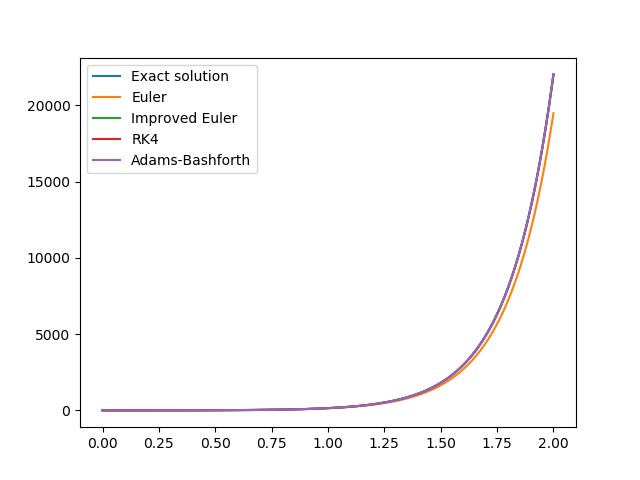

interactive(children=(FloatSlider(value=0.005, description='h', max=0.01, min=0.001, step=0.001), Output()), _…

In [6]:
def simple_f(t, x):
    return 5*x

def simple_f_exact(t_list, f, x0):
    return np.exp(5 * t_list)

eq2 = DifferentialEquation(simple_f, x0 = 1, t_max = 2)
eq2.add_solution(simple_f_exact, title = "Exact solution", exact = True)
eq2.add_solution(euler, title = "Euler")
eq2.add_solution(improved_euler, title = "Improved Euler")
eq2.add_solution(rk4, title = "RK4")
eq2.add_solution(adams_bashforth, title = "Adams-Bashforth")
eq2.plot_interactive(h_min = 0.001, h_max = 0.01, h_step = 0.001)

In [37]:
eq = DifferentialEquation(sample_f, x0 = 1, t_max = 1)
%timeit eq.add_solution(sample_exact, h = 0.0001, exact = True)
%timeit eq.add_solution(euler, h = 0.0001)
%timeit eq.add_solution(improved_euler, h = 0.0001)
%timeit eq.add_solution(modified_euler, h = 0.0001)
%timeit eq.add_solution(rk4, h = 0.0001)
%timeit eq.add_solution(adams_bashforth, h = 0.0001)

239 µs ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.1 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.3 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.2 ms ± 481 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
95.3 ms ± 816 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
77.8 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
